**Importing Libraries that can be used later**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

Defining the data transformation and lodaing the STL dataset,

Source of dataset: https://cs.stanford.edu/~acoates/stl10/


In [5]:
# Define transformations

''' mean and standard deviation are both set to 0.5 for each channel,
    normalization will transform the pixel values of each channel
    from a range of [0, 1] to a range of [-1, 1]'''
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64 pixels (original images in the dataset are 96 by 96 and 3 color channels)
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

''' files are split into data and label files with suffixes:
train_X.bin, train_y.bin, test_X.bin and test_y.bin.
Within each, the values are stored as tightly packed arrays of uint8's'''
# Load STL-10 dataset
train_dataset = datasets.STL10(root='./data', split='train', download=True, transform=transform)
test_dataset = datasets.STL10(root='./data', split='test', download=True, transform=transform)

# Split the test dataset into validation and test sets as there are many test samples data
val_size = 4000
test_size = len(test_dataset) - val_size
print(test_size)
val_dataset, test_dataset = random_split(test_dataset, [val_size, test_size])
''' Three loaders for training, validation, testing '''

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

100%|██████████| 2640397119/2640397119 [07:41<00:00, 5725975.45it/s]


Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified
4000


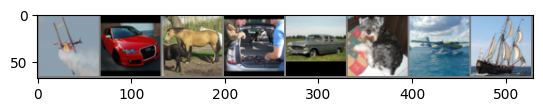

Labels: [0 2 6 2 2 5 0 8]


In [12]:
# Function to unnormalize and show images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)  # Use the built-in next() function

# Show images
imshow(torchvision.utils.make_grid(images[:8]))  # Show the first 8 images
print('Labels:', labels[:8].numpy())  # Print the corresponding labels

In [13]:
class SimpleCNN(nn.Module):
    def __init__(self):
        # inheritance and constructor
        super(SimpleCNN, self).__init__()
        '''first convolutional layer.
        It takes in an image with 3 channels, applies 16 filters (or kernels),
        each of size 3x3. padding=1 ensures that the output image size is
        the same as the input by adding a one-pixel border around the input.'''
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        ''' max pooling layer with a 2x2 window and a stride of 2,
        reduces the dimensions by half'''
        self.pool = nn.MaxPool2d(2, 2)

        ''' First fully connected layer'''
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        ''' Second fully connected layer'''
        self.fc2 = nn.Linear(128, 10)
        ''' ReLU activation function is applied  after each convolutional
        and fully connected layer to introduce non-linearity'''
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 32 * 16 * 16)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return self.softmax(x)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [15]:
# Training and validation

# Initialize lists to store training and validation metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')


Epoch 1/20, Train Loss: 1.7412, Train Accuracy: 35.38%, Val Loss: 1.5144, Val Accuracy: 44.00%
Epoch 2/20, Train Loss: 1.3877, Train Accuracy: 49.34%, Val Loss: 1.4344, Val Accuracy: 47.98%
Epoch 3/20, Train Loss: 1.1825, Train Accuracy: 57.42%, Val Loss: 1.3544, Val Accuracy: 49.77%
Epoch 4/20, Train Loss: 0.9854, Train Accuracy: 64.50%, Val Loss: 1.3374, Val Accuracy: 52.62%
Epoch 5/20, Train Loss: 0.7986, Train Accuracy: 72.26%, Val Loss: 1.4120, Val Accuracy: 52.17%
Epoch 6/20, Train Loss: 0.5857, Train Accuracy: 79.88%, Val Loss: 1.4254, Val Accuracy: 53.50%
Epoch 7/20, Train Loss: 0.4141, Train Accuracy: 86.26%, Val Loss: 1.6809, Val Accuracy: 52.30%
Epoch 8/20, Train Loss: 0.2621, Train Accuracy: 92.02%, Val Loss: 1.7468, Val Accuracy: 54.42%
Epoch 9/20, Train Loss: 0.1505, Train Accuracy: 96.24%, Val Loss: 2.1482, Val Accuracy: 52.75%
Epoch 10/20, Train Loss: 0.0906, Train Accuracy: 97.96%, Val Loss: 2.2508, Val Accuracy: 54.70%
Epoch 11/20, Train Loss: 0.0479, Train Accuracy: 

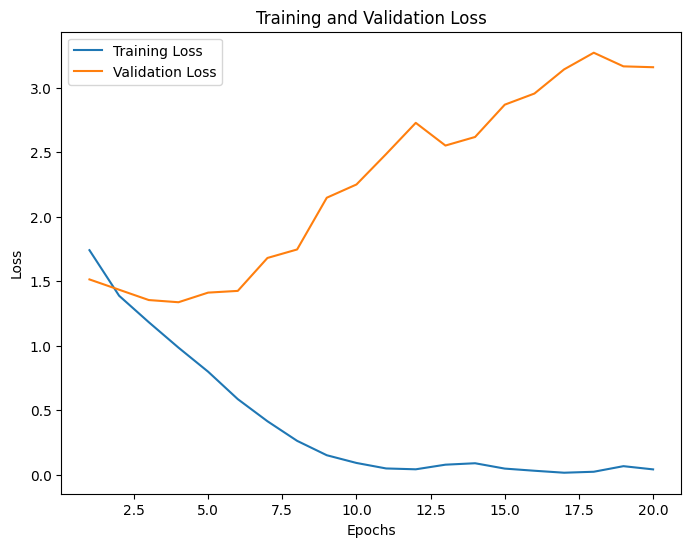

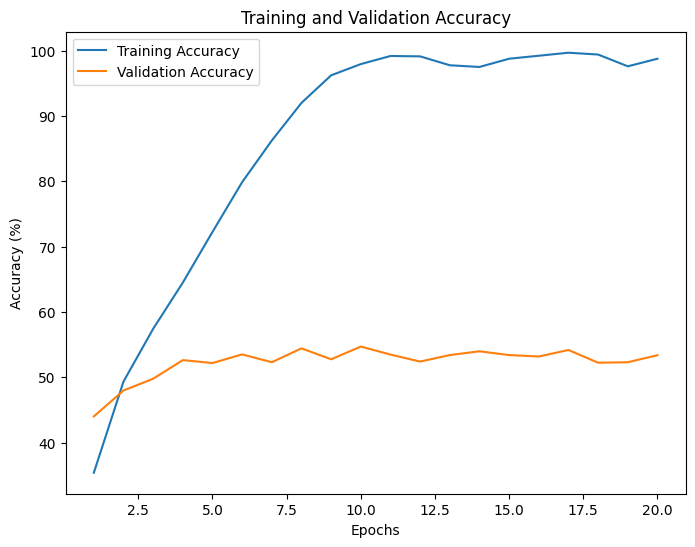

In [25]:

# Plot training and validation loss
plt.figure(figsize=(8,6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(8,6))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [17]:
# Testing
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_loss /= len(test_loader)
test_accuracy = 100 * correct / total

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 3.0532, Test Accuracy: 54.83%


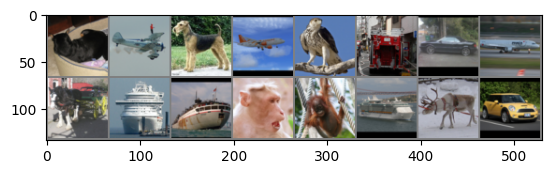

GroundTruth:  5 0 5 0 1 9 2 0 6 8 8 7 7 8 4 2
  Predicted:  3 1 4 0 8 4 2 0 7 8 8 1 7 8 3 2


In [24]:
# Get a batch of test data
no_of_samples = 16
dataiter = iter(test_loader)
images, labels = next(dataiter)  # Use the built-in next() function

# Show images
imshow(torchvision.utils.make_grid(images[:no_of_samples]))
print('GroundTruth: ', ' '.join(f'{labels[j]}' for j in range(no_of_samples)))

images = images.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('  Predicted: ', ' '.join(f'{predicted[j].item()}' for j in range(no_of_samples)))
